In [3]:
# -*- coding: utf-8 -*-
__author__ = 'NadyaMotina'

import time
import codecs
import pandas
import operator
import igraph
import community
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import Word2Vec
from itertools import combinations
from transliterate import translit

from sklearn.cluster import SpectralClustering

In [4]:
start_time = time.time()
#model = Word2Vec.load_word2vec_format('../../Models/webcorpora.model.bin', binary=True)
model = Word2Vec.load_word2vec_format('../../Models/ruscorpora.model.bin', binary=True)
print 'Model loaded successfully. It took ', time.time() - start_time, ' seconds'

Model loaded successfully. It took  7.28194093704  seconds


# networkx

In [14]:
def build_rng(word, model, topn=10):
    # 1) find N most similar words from the model
    # 2) for each combination of 2 words find if there is some other neighbor in between them
    #    * if there is no such word: add an edge
    # output: graph object
    wg = nx.DiGraph()
    neighbors = model.most_similar(word, topn=topn)
    neighbors.append((word, 1.0))
    for pair in combinations(neighbors, 2):
        word0 = pair[0][0]
        word1 = pair[1][0]
        similarity = model.similarity(word0, word1)
        if similarity > 0:
            remaining = [vertex for vertex in neighbors if vertex != pair[0] \
                         and vertex != pair[1]]
            for vertex in remaining:
                drawedge = True
                candidate = vertex[0]
                if model.similarity(candidate, word1) > similarity \
                and model.similarity(candidate, word0) > similarity:
                    drawedge = False
                    break
                if drawedge == True:
                    # Cyrillic symbols cause error for graph plotting
                    # so we need to transliterate words
                    w1 = translit(pair[0][0], 'ru', reversed=True) 
                    w2 = translit(pair[1][0], 'ru', reversed=True)
                    wg.add_edge(w1, w2, weight=similarity)
    # remove the starting node to see only resulting clusters
    wg.remove_node(translit(word, 'ru', reversed=True))
    return wg.to_undirected(), translit(word, 'ru', reversed=True)
 
def draw_rng(wg):
    # draw high cosine similarity edges bold
    # and low cosine similarity edges faint and dashed
    # print nx.info(wg)    
    threshold = 0.45
    elarge=[(u,v) for (u,v,d) in wg.edges(data=True) if d['weight'] > threshold]
    esmall=[(u,v) for (u,v,d) in wg.edges(data=True) if d['weight'] <= threshold]
    plt.figure(figsize=(10,10))
    plt.axis('off')
    pos = nx.spring_layout(wg)
    partition = louvain_communities(wg)
    values = [partition.get(node) for node in wg.nodes()]
    nx.draw_networkx_nodes(wg, pos, node_size = 200, node_color = values)
    nx.draw_networkx_edges(wg, pos, edgelist=elarge, width=4, alpha=0.7, edge_color='g')
    nx.draw_networkx_edges(wg, pos, edgelist=esmall, width=4, alpha=0.2, edge_color='b', style='dashed')
    nx.draw_networkx_labels(wg, pos, font_size=16, font_family='sans-serif')
    plt.show()
    
def louvain_communities(graph):
    # Compute the partition of the graph nodes which maximises the modularity  
    # using the Louvain heuristices
    partition = community.best_partition(graph)
    for i in list(set(partition.values())):
        print i, '_________________________'
        for j in partition:
            if partition[j] == i:
                print translit(j, 'ru')
    return partition

0 _________________________
космос_С
окружаюсчее_С
планета_С
вселенная_С
царство_С
1 _________________________
сусчностЬ_С
действителЬностЬ_С
жизнЬ_С
миропорядок_С
бытие_С
природа_С
реалЬностЬ_С
сусчество_С
2 _________________________
премудростия_С
сроднятЬ_В
творение_С
подлунная_С
мироздание_С
тварЬ_С
тварный_А
3 _________________________
страна_С
россия_С
мироустройство_С
европа_С
человечество_С


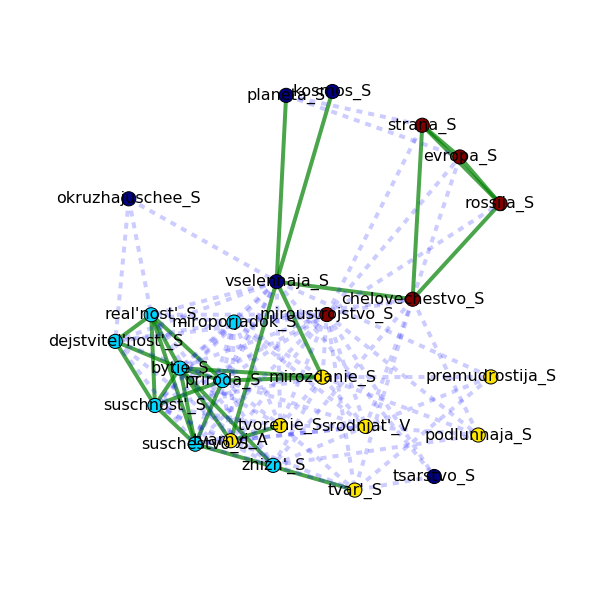

In [15]:
# model can read only words with a POS-tag (S=noun, V=verb, A=adjective)

word = 'мир_S'.decode('utf8')
graph, node = build_rng(word, model, topn=25)
draw_rng(graph)

## save a graph for Gephi
# nx.write_graphml(graph, "test.graphml", encoding='utf-8') 

# igraph

In [17]:
def i_build_rng(word, model, topn=10):
    # 1) find N most similar words from the model
    # 2) for each combination of 2 words find if there is some other neighbor in between them
    #    * if there is no such word: add an edge
    # output: graph object
    wg = igraph.Graph()
    neighbors = model.most_similar(word, topn=topn)
    neighbors.append((word, 1.0))
    for pair in combinations(neighbors, 2):
        word0 = pair[0][0]
        word1 = pair[1][0]
        similarity = model.similarity(word0, word1)
        if similarity > 0:
            remaining = [vertex for vertex in neighbors if vertex != pair[0] \
                         and vertex != pair[1]]
            for vertex in remaining:
                drawedge = True
                candidate = vertex[0]
                if model.similarity(candidate, word1) > similarity \
                and model.similarity(candidate, word0) > similarity:
                    drawedge = False
                    break
                if drawedge == True:
                    w1 = pair[0][0].encode('utf8') 
                    w2 = pair[1][0].encode('utf8') 
                    try: wg.vs.find(w1)
                    except: wg.add_vertices(w1)
                    try: wg.vs.find(w2)
                    except: wg.add_vertices(w2)
                    if wg.are_connected(w1, w2) is False:
                        wg.add_edge(w1, w2, weight=similarity)
    # remove the starting node to see only resulting clusters
    wg.delete_vertices(word.encode('utf8') )
    return wg, word.encode('utf8') 

In [72]:
word = 'мир_S'.decode('utf8')
graph, node = i_build_rng(word, model, topn=25)

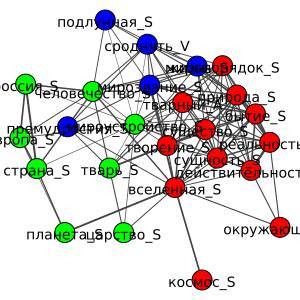

In [73]:
color_list = ['red','blue','green','cyan','pink','orange','grey','yellow','white','black','purple']
graph.vs["label"] = graph.vs["name"]
community = graph.community_multilevel()
layout = graph.layout("kk")
igraph.plot(graph, bbox = (300,300), layout = layout, \
            vertex_color=[color_list[x] for x in community.membership], \
           edge_width = [i*3 for i in graph.es['weight']])

In [74]:
community = graph.community_multilevel()
print community

Clustering with 25 elements and 3 clusters
[0] вселенная_S, реальность_S, природа_S,
    действительность_S, бытие_S, тварный_A,
    существо_S, окружающее_S, космос_S,
    сущность_S, творение_S, миропорядок_S
[1] мироздание_S, премудростия_S, жизнь_S,
    подлунная_S, сроднять_V
[2] человечество_S, царство_S, планета_S,
    страна_S, европа_S, россия_S, тварь_S,
    мироустройство_S


In [75]:
community = graph.community_label_propagation()
print community

Clustering with 25 elements and 1 clusters
[0] вселенная_S, человечество_S, мироздание_S,
    реальность_S, природа_S,
    действительность_S, царство_S, бытие_S,
    тварный_A, существо_S, окружающее_S,
    космос_S, планета_S, сущность_S,
    премудростия_S, творение_S, страна_S,
    жизнь_S, европа_S, россия_S, тварь_S,
    миропорядок_S, подлунная_S, сроднять_V,
    мироустройство_S


In [76]:
community = graph.community_leading_eigenvector()
print community

Clustering with 25 elements and 2 clusters
[0] вселенная_S, мироздание_S, реальность_S,
    природа_S, действительность_S, бытие_S,
    тварный_A, существо_S, окружающее_S,
    космос_S, сущность_S, творение_S, жизнь_S,
    миропорядок_S
[1] человечество_S, царство_S, планета_S,
    премудростия_S, страна_S, европа_S,
    россия_S, тварь_S, подлунная_S, сроднять_V,
    мироустройство_S


In [ ]:
# try SpectralClustering (but need to specify number of clusters)

# adjacency matrix
df = nx.to_pandas_dataframe(graph)

n = 4
clusters = SpectralClustering(n_clusters = n, affinity="precomputed").fit_predict(df)
for i in range(n):
    print i
    for j in range(len(clusters)):
        if clusters[j] == i:
            print df.columns[j]